# Determining a prospective tariff for a telecom company

Analysis of "Megaline" company's tariffs. Customers are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which plan makes more money. It is necessary to make a preliminary analysis of tariffs on a small sample of clients. Data from 500 "Megaline" users are available: who they are, where they come from, what tariff they use, how many calls and messages each sent in 2018. We need to analyze customer behavior and draw a conclusion - which tariff is better.

Structure:

1. Study of general information
2. Preparing data for analysis
3. Analyzing data
4. Testing of hypotheses
5. Conclusion

##  General Information

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install -U seaborn
import seaborn as sns
sns.set_style(style='darkgrid')
from scipy import stats as st
from datetime import datetime, date, time
import math

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.2 MB/s eta 0:00:01


In [20]:
ds_calls = pd.read_csv('/datasets/calls.csv')
ds_calls.describe()
ds_calls.info()
ds_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
ds_internet= pd.read_csv('/datasets/internet.csv')
ds_internet.info()
ds_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
ds_messages = pd.read_csv('/datasets/messages.csv')
ds_messages.info()
ds_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
ds_tariffs = pd.read_csv('/datasets/tariffs.csv')
ds_tariffs.info()
ds_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
ds_users = pd.read_csv('/datasets/users.csv')
ds_users.info()
ds_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


There are 5 arrays: calls, internet and messages, which contain information on subscriber activity: calls, internet usage and sending messages. Tariffs present the terms of tariffs, and users present the key information about the subscribers. The number of observations differs in each ds, which indicates a different number of observations by activity. Let's first consider the largest dataset - calls

##  Preprocessing

In this section we will process the data to get a summary table. Also, find the number of calls made and minutes spent by month, the number of messages sent by month, and the amount of Internet traffic used by month

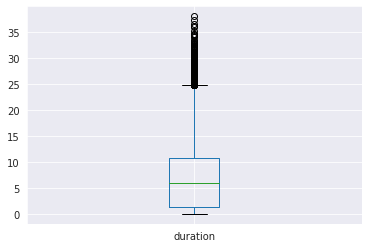

In [7]:
ds_calls.boxplot('duration');

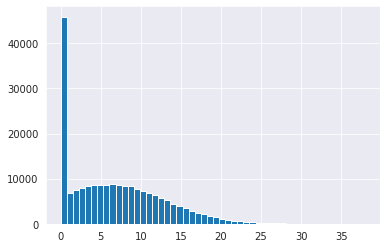

In [8]:
ds_calls['duration'].hist(bins=50,range=(0,38));

Regarding the duration of the calls, there is a large number of zero values (>40k), we can assume that these were missed calls and do not need to take them into account in the calculations. 

We need to convert the date to the right type, to allocate the month as a separate variable and generate a pivot table after processing

In [9]:
ds_calls['duration'].apply(np.ceil)
ds_calls['duration'] = ds_calls['duration'].astype('int')
#ds_calls = ds_calls.loc[calls['duration'] != 0]

ds_calls['call_date'] = pd.to_datetime(ds_calls['call_date'], format='%Y-%m-%d')
ds_calls['month'] = pd.DatetimeIndex(ds_calls['call_date']).month
ds_calls_p = ds_calls.pivot_table(index=('user_id','month'),values='duration',aggfunc=('sum','count'))
ds_calls_group = pd.DataFrame(ds_calls_p.to_records())
ds_calls_group = ds_calls_group.rename(columns={'count': 'calls_per_month', 'sum': 'min_per_month'})
ds_calls_group.head()

,user_id,month,calls_per_month,min_per_month
0,1000,5,22,142
1,1000,6,43,144
2,1000,7,47,299
3,1000,8,52,367
4,1000,9,58,421


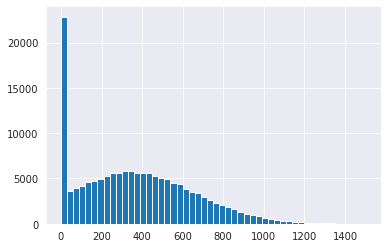

In [10]:
ds_internet['mb_used'].hist(bins=50,range=(0,1500))

In [11]:
ds_internet['mb_used'].apply(np.ceil)
ds_internet['mb_used'] = ds_internet['mb_used'].astype('int')
#ds_internet = ds_internet.loc[ds_internet['mb_used'] != 0]

ds_internet['session_date'] = pd.to_datetime(ds_internet['session_date'], format='%Y-%m-%d')
ds_internet['month'] = pd.DatetimeIndex(ds_internet['session_date']).month
ds_internet_p = ds_internet.pivot_table(index=('user_id','month'),values='mb_used',aggfunc=('sum','count'))
ds_internet_group = pd.DataFrame(ds_internet_p.to_records())
ds_internet_group = ds_internet_group.rename(columns={'count': 'ses_per_month', 'sum': 'mb_per_month'})
ds_internet_group.head()

,user_id,month,ses_per_month,mb_per_month
0,1000,5,5,2252
1,1000,6,49,23213
2,1000,7,29,13988
3,1000,8,29,14043
4,1000,9,27,14556


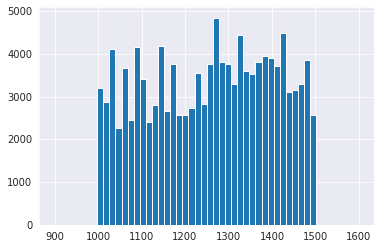

In [12]:
ds_messages['user_id'].hist(bins=50,range=(900,1600))

In [13]:
ds_messages['message_date'] = pd.to_datetime(ds_messages['message_date'], format='%Y-%m-%d')
ds_messages['month'] = pd.DatetimeIndex(ds_messages['message_date']).month
ds_messages_p = ds_messages.pivot_table(index=('user_id','month'),values='message_date',aggfunc=('count'))
ds_messages_group = pd.DataFrame(ds_messages_p.to_records())
ds_messages_group = ds_messages_group.rename(columns={'message_date': 'mes_per_month'})
ds_messages_group.head()

,user_id,month,mes_per_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [14]:
ds_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [15]:
ds_tariffs = ds_tariffs.rename(columns={'tariff_name': 'tariff'})
ds_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Объеденим переменные в одну таблицу и избавимся от переменных, которые не влияют на анализ, например имя и фамилия

In [16]:
ds_users['churn_date'].fillna(0,inplace=True)                    
ds_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,0,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,0,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,0,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [17]:
ds_stat =( 
    ds_users.join(ds_tariffs.set_index('tariff'), on='tariff')
    .merge(ds_calls_group, on=['user_id'], how='outer')
    .merge(ds_internet_group, on=['user_id','month'], how='outer')
    .merge(ds_messages_group, on=['user_id','month'], how='outer')
)

ds_stat = ds_stat.drop(columns=['first_name', 'last_name', 'age'])
ds_stat.head().T

,0,1,2,3,4
user_id,1000,1000,1000,1000,1000
churn_date,0,0,0,0,0
city,Краснодар,Краснодар,Краснодар,Краснодар,Краснодар
reg_date,2018-05-25,2018-05-25,2018-05-25,2018-05-25,2018-05-25
tariff,ultra,ultra,ultra,ultra,ultra
messages_included,1000,1000,1000,1000,1000
mb_per_month_included,30720,30720,30720,30720,30720
minutes_included,3000,3000,3000,3000,3000
rub_monthly_fee,1950,1950,1950,1950,1950
rub_per_gb,150,150,150,150,150


##  Data analysis

### Smart tariff customer research

In [18]:
ds_smart = ds_stat.query('tariff == "smart"')
ds_smart = ds_smart.loc[:,['min_per_month','mb_per_month','mes_per_month']]
ds_smart.describe()

,min_per_month,mb_per_month,mes_per_month
count,2223.000000,2222.000000,1916.000000
mean,372.446694,16195.842484,38.747390
std,169.012757,5860.460985,26.817396
min,0.000000,0.000000,1.000000
25%,252.000000,12637.500000,17.000000
50%,375.000000,16481.000000,34.000000
75%,485.000000,20024.750000,55.000000
max,1275.000000,38510.000000,143.000000


In [19]:
def print_hist(data, column):       
    sns.histplot(data=data, x=column, bins=50, kde=True)
        
    variance = math.ceil(np.var(data[column], ddof=1))
    std_dev = math.ceil(np.sqrt(variance))
    mean = math.ceil(data[column].mean())

    print('var:{}'.format(variance),'std_dev:{}'.format(std_dev),'mean:{}'.format(mean))    

var:28566 std_dev:170 mean:373


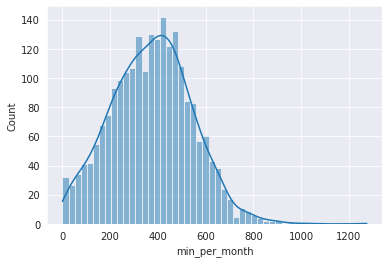

In [20]:
print_hist(ds_smart, "min_per_month")   

var:34345003 std_dev:5861 mean:16196


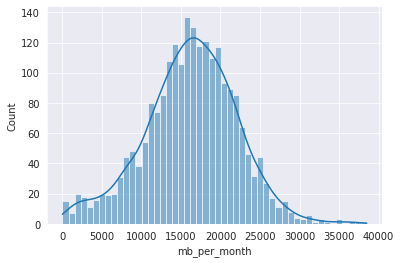

In [21]:
print_hist(ds_smart, "mb_per_month")   

var:720 std_dev:27 mean:39


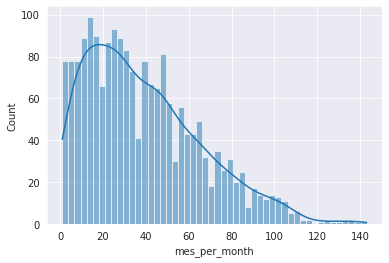

In [22]:
print_hist(ds_smart, "mes_per_month")   

1. Minutes usage - the distribution of the use of minutes tends to normal. On average, users use 373 minutes, thus do not exceed the time limit in accordance with the terms of the package (500). Overuse of minutes is in the limit of 800 minutes, so users spend up to 900 rubles extra. If users have overdraft only on minutes, then the transition to the tariff ultra for them will not be appropriate;

2. Internet traffic usage - the distribution of mb usage tends to be normal. The average use of mb is 16196 mb, which slightly exceeds the limit of the package (15360). There is also a significant portion of users who exceed the limit and, accordingly, pay extra for the use of the Internet. The excess is in the range up to 30 gb, so some users overpay for 15 extra gb, which amounts to 3000 rubles per month + 500 rubles regular fee for the tariff. Users who overspend the Internet more than 7 gb can be targeted advertising and offer to switch to the tariff ultra;

3. Message usage - the distribution of message usage has a shift to the left, so most users use the service in accordance with the limit of 50 messages. Overconsumption of messages is within 100 messages, that is, the additional cost of 150 rubles, which can not be an additional motivation for switching to the tariff ultra

In [23]:
def calc_profit(row):
    mes_included = row['messages_included']
    mb_per_month_included = row['mb_per_month_included']
    minutes_included = row['minutes_included']
    min_per_month = row['min_per_month']
    mb_per_month = row['mb_per_month']
    mes_per_month = row['mes_per_month']
    rub_per_gb = row['rub_per_gb']
    rub_per_message = row['rub_per_message']
    rub_per_minute = row['rub_per_minute']
    
    over_per_month = 0
    
    if mes_per_month > mes_included:
        over_per_month += (mes_per_month - mes_included)*rub_per_message
    if mb_per_month > mb_per_month_included:
        over_per_month += math.ceil((mb_per_month-mb_per_month_included)/1024)*rub_per_gb
    if min_per_month > minutes_included:
        over_per_month += (min_per_month - minutes_included)*rub_per_minute
        
    return over_per_month 


ds_stat['profit'] = ds_stat.apply(calc_profit, axis=1)
ds_stat['rev_per_user'] = ds_stat['profit'] + ds_stat['rub_monthly_fee']

ds_stat['rev_per_user'].describe()

count    3182.000000
mean     1480.589252
std       788.586262
min       550.000000
25%       676.000000
50%      1550.000000
75%      1950.000000
max      6425.000000
Name: rev_per_user, dtype: float64

### Ultra tariff customer research

In [24]:
ds_ultra = ds_stat.query('tariff == "ultra"')
ds_ultra = ds_ultra.loc[:,['min_per_month','mb_per_month','mes_per_month']]
ds_ultra.describe()

,min_per_month,mb_per_month,mes_per_month
count,951.000000,941.000000,762.000000
mean,484.652997,19650.944740,61.195538
std,273.203320,9969.482434,44.716597
min,0.000000,0.000000,1.000000
25%,276.000000,11863.000000,25.000000
50%,468.000000,19413.000000,52.000000
75%,674.500000,26840.000000,88.000000
max,1484.000000,49701.000000,224.000000


var:74641 std_dev:274 mean:485


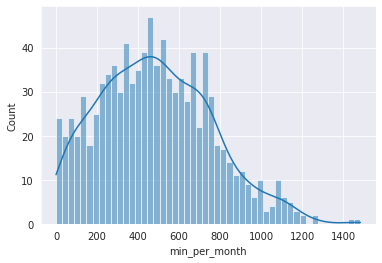

In [25]:
print_hist(ds_ultra, "min_per_month")   

var:99390580 std_dev:9970 mean:19651


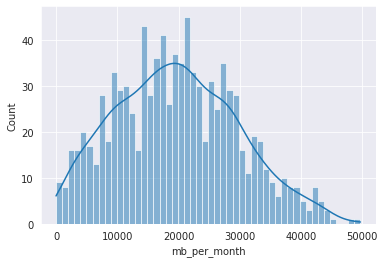

In [26]:
print_hist(ds_ultra, "mb_per_month") 

var:2000 std_dev:45 mean:62


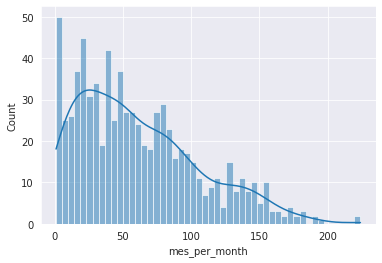

In [27]:
print_hist(ds_ultra, "mes_per_month") 

The most similar distribution of aggregated average values by users turned out for Internet use, which confirms the stable behavioral habits of users - this information can be useful for further revision of tariff plans

### Tariffs comparison

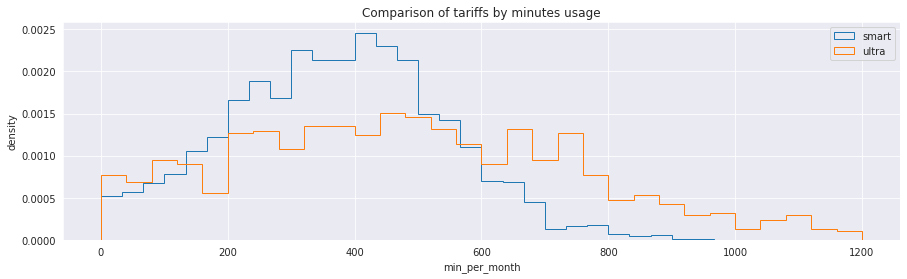

In [28]:
plt.figure(figsize=(15,4))

ds_smart['min_per_month'].hist(bins=30,range=(0,1000),density=True,label='smart',histtype='step')
ds_ultra['min_per_month'].hist(bins=30,range=(0,1200),density=True,label='ultra',histtype='step')
plt.xlabel('min_per_month')
plt.ylabel('density')
plt.title('Comparison of tariffs by minutes usage')
plt.legend()
plt.show()

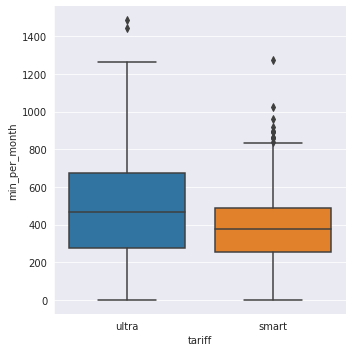

In [29]:
sns.catplot(x='tariff',y='min_per_month',kind='box',data=ds_stat);

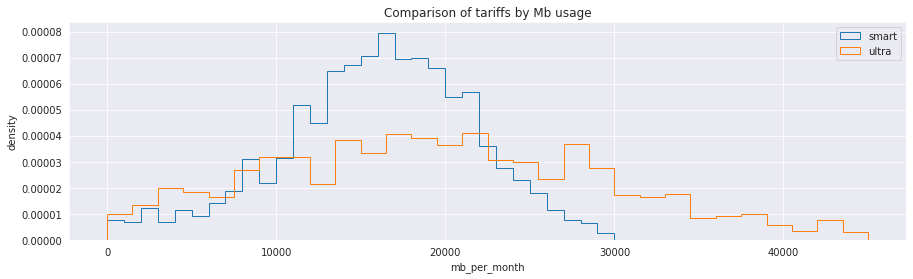

In [30]:
plt.figure(figsize=(15,4))

ds_smart['mb_per_month'].hist(bins=30,range=(0,30000),density=True,label='smart',histtype='step')
ds_ultra['mb_per_month'].hist(bins=30,range=(0,45000),density=True,label='ultra',histtype='step')
plt.xlabel('mb_per_month')
plt.ylabel('density')
plt.title('Comparison of tariffs by Mb usage')
plt.legend()
plt.show()

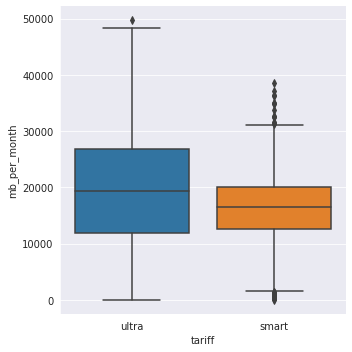

In [31]:
sns.catplot(x='tariff',y='mb_per_month',kind='box',data=ds_stat);

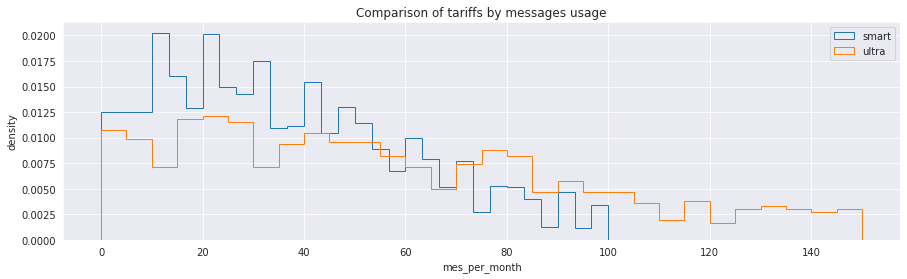

In [32]:
plt.figure(figsize=(15,4))

ds_smart['mes_per_month'].hist(bins=30,range=(0,100),density=True,label='smart',histtype='step')
ds_ultra['mes_per_month'].hist(bins=30,range=(0,150),density=True,label='ultra',histtype='step')
plt.xlabel('mes_per_month')
plt.ylabel('density')
plt.title('Comparison of tariffs by messages usage')
plt.legend()
plt.show()

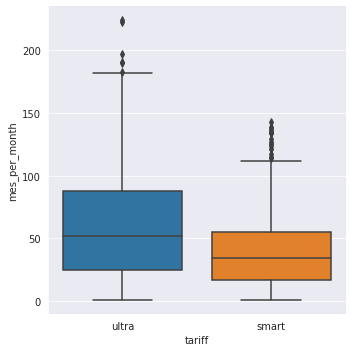

In [33]:
sns.catplot(x='tariff',y='mes_per_month',kind='box',data=ds_stat);

This comparison again clearly shows that Ultra tariff users spend the tariff more generously than Smart tariff users 

/home/jovyan/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


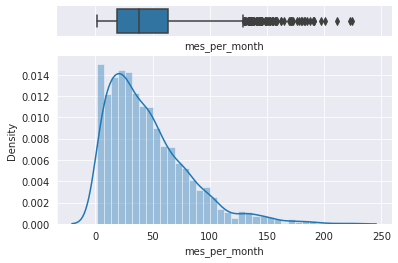

In [34]:
x = ds_stat['mes_per_month']

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## Проверка гипотез

In [35]:
ds_ultra_r = ds_stat.query('tariff == "ultra"')
ds_ultra_r = ds_ultra_r['rev_per_user']

ds_smart_r = ds_stat.query('tariff == "smart"')
ds_smart_r = ds_smart_r['rev_per_user']

ds_mos = ds_stat.query('city == "Москва"')
ds_mos =  ds_mos['rev_per_user']

ds_other = ds_stat.query('city != "Москва"')
ds_other =  ds_other['rev_per_user']

**Гипотеза 1:**

**H0: average revenue of Ultra and Smart tariff users is different**

**H1: average revenue of Ultra and Smart tariff users is not different**


In [36]:
alpha = 0.05

results = st.ttest_ind(
    ds_ultra_r, 
    ds_smart_r)

print('Average revenue using Smart:{}'.format(math.ceil(ds_smart_r.mean())))
print('Average revenue using  Ultra:{}'.format(math.ceil(ds_ultra_r.mean())))

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Reject H0")
else:
    print("It wa not possible to reject H0")

Средняя выручка по пользователю тарифа Smart:1228
Средняя выручка по пользователю тарифа Ultra:2070
p-значение: 8.542639110889139e-192
Отвергаем нулевую гипотезу


We reject the null hypothesis with a significance level of 5% and a p-value of 8.542639110889139e-192. We used a two-sided test, since the average can be shifted both to the right and to the left. The Ultra tariff brings in 40% more revenue and it was initially expected that the revenue of the two tariffs was different. With this conclusion, marketing campaigns can be done for each tariff separately.

**Гипотеза 2:**

**H0: average revenue of users from Moscow differs from the revenue of users from other regions**

**H1: average revenue of users from Moscow does not differ from the revenue of users from other regionsз**

In [37]:
alpha = 0.05

results = st.ttest_ind(
    ds_other, 
    ds_mos)

print('Average revenu in Moscow:{}'.format(math.ceil(ds_mos.mean())))
print('Average revenue for other regions:{}'.format(math.ceil(ds_other.mean())))

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Reject H0")
else:
    print("It wa not possible to reject H0")

Средняя выручка по пользователю из МСК:1507
Средняя выручка по пользователей других регионов:1475
p-значение: nan
Не получилось отвергнуть нулевую гипотезу


For a given statistical significance level of 5%, we cannot reject the null hypothesis. In this case we used a two-sided test, as the average can be shifted both to the right and to the left. It turned out that in the available date in Moscow and the regions are paid almost equally, although initially it seemed that the costs in the capital more. This is for the best, you can skip the step of targeting by geography of users.

##  Conclusion

In [38]:
ds_stat_p_rev = (
    ds_stat.pivot_table(index='tariff',values=('rev_per_user'),aggfunc=('sum','mean','count'))
    .round(0)
)
ds_stat_p_rev

,count,mean,sum
tariff,,,
smart,2225,1227.0,2730635.0
ultra,957,2070.0,1980600.0


In absolute terms, Smart brought in more revenue, due to the greater number of users, but the specific revenue is much higher from Ultra tariff users. We would like to note that we confirmed the statistical significance of differences in the average revenue of tariff users, but we could not find statistically significant differences in the average revenue by region.

However, we would like to point out an interesting feature of the average revenue from Smart tariff users, it exceeds the monthly fee by 650 rubles, which suggests that the users of this tariff constantly pay extra for extra traffic and minutes. Let's take a look at the overcharges:

In [39]:
ds_stat_p_over = (
    ds_stat.pivot_table(index='tariff',values=('profit'),aggfunc=('sum','mean','count'))
    .round(0)
)
ds_stat_p_over

,count,mean,sum
tariff,,,
smart,2225,677.0,1506885.0
ultra,957,120.0,114450.0


1.5 million rubles earned due to overcharges by Smart tariff users, which is good, but carries the risk of user outflow due to tariffs that do not meet their needs. We can offer these users to switch to Ultra tariff, but we understand that the average amount of overspending is 680 rubles, and the difference in tariffs is 1400 rubles, and it makes no sense for users to switch to this tariff, respectively targeted advertising is not helpful here. During the research we determined that the main overdraft is connected with the significant overdraft of the Internet traffic of Smart tariff users and reaches 30gb, but the main part of users is within the range of 15-20gb. At the same time the consumption of messages and minutes in both tariffs differs not so dramatically and often does not even reach the limit.

Thus we can conclude that perhaps it is not necessary to spend the advertising budget, and to review the tariffs, to make an intermediate tariff with an internet limit up to 20 gb. and add an unlimited tariff, as in the tariff ultra there are such users and they could be interested in this offer.